# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: \<team name here\> 

Roll number: \<Roll number here (in sorted order)\>

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp
import open3d as o3d
import cv2
import pandas as pd
# Utilities
import copy
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.

1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


## Answer 1: Affine, Similarity and Euclidean Transform

Description as well as the properties preserved by different transforms are summarized below. Their homogeneous transformation matrices are also described.


### Affine Transform

It is a transformation that is any sequence of **rotation** (rotate points about an axis by a given angle), directional **scaling** (scaling the points differently in different direction) and **translation** (offsetting or moving the points)

It can be described by a transformation

$$ 
\begin{bmatrix}
\mathbf{y} \\
1
\end{bmatrix} = 
\left[
\begin{array}{ccc|c}
& \mathbf{A} & & \mathbf{b} \\
0 & \cdots & 0 & 1
\end{array}
\right]
\begin{bmatrix}
\mathbf{x} \\
1
\end{bmatrix}
$$

Where $\mathbf{x}$ is the input vector, $\mathbf{y}$ is the output vector (result of transformation). The matrix $\mathbf{A}$ contains information about rotation and scaling (SVD of $\mathbf{A}$ might reveal more about it) of $\mathbf{x}$ and the vector $\mathbf{b}$ is the translation vector. The above matrix equation can be more simply written as

$$ \mathbf{y} = \mathbf{A} \mathbf{x} + \mathbf{b} $$

This type of transformation maintains the following invariant properties (assume transformation happening on 2D vectors for visualizing, but the same concepts can be extended to higher dimensions)

- **Parallelism**: If two lines are parallel before the transform, they'll remain parallel after the transform as well.

However, the following properties are not maintained

- **Angles**: If two lines make a certain angle before the transformation, there is no guarantee that they'll maintain the same angle after transformation.
- **Lengths**: SInce scaling is involved, the lengths of vectors need not be preserved. They'll not remain of the same length after the transformation.


### Similarity Transform

> **Note**: Assuming that the _similarity transform_ described here is not representing a transformation in one frame, in another frame.

A similarity transform is a mix of **scaled rotation** and a **translation**. The main difference from affine transform is that the scaling happens to the entire vector space (uniform in all directions).

It can be described by a transformation

$$
\begin{bmatrix}
\mathbf{y} \\
1
\end{bmatrix}
=
\left [
\begin{array}{ccc|c}
& m\mathbf{R} & & \mathbf{b} \\
0 & \cdots & 0 & 1
\end{array}
\right ]
\begin{bmatrix}
\mathbf{x} \\
1
\end{bmatrix}
$$

Where $\mathbf{x}$ is the input vector, $\mathbf{y}$ is the output vector (result of transformation). The matrix $\mathbf{R}$ is formed by orthonormal basis vectors (in the respective dimensional space) such that $\left | \mathbf{R} \right | = +1$. Such a group of matrices are called _special orthogonal_ matrices. It can be scaled by $m$ (a scalar). The vector $\mathbf{b}$ is a translation vector. The above matrix equation can more simply be written as

$$ \mathbf{y} = m \mathbf{R\,x} + \mathbf{b} $$

This type of transformation maintains the following invariant properties (assume transformation happening on 2D vectors for visualizing, but the same concepts can be extended to higher dimensions)

- **Angles**: If two lines make a particular angle before transformation, they will maintain the same angle after transformation. This is because the matrix $\mathbf{R}$ inherently preserves angles. Note that scaling is uniform for all axis here, unlike the affine transform case.
- **Parallelism**: If two lines are parallel before the transform, they will remain parallel after the transform. This follows from the fact that angles are preserved.

However, the following properties are not maintained

- **Length**: Since uniform scaling is observed, the resultant vectors need not be of the same length. But, they'll be a scalar multiple of their original lengths (for untranslated free vectors).


### Euclidean Transform

Euclidean transforms, or _Rigid Body Transforms_ are transformation that preserve the length of vectors as well. They only rotate or translate (offset) vectors, they do not involve scaling.

It can be described by a transformation

$$
\begin{bmatrix}
\mathbf{y} \\
1
\end{bmatrix}
=
\left [
\begin{array}{ccc|c}
& \mathbf{R} & & \mathbf{b} \\
0 & \cdots & 0 & 1
\end{array}
\right ]
\begin{bmatrix}
\mathbf{x} \\
1
\end{bmatrix}
$$

Where $\mathbf{x}$ is the input vector, $\mathbf{y}$ is the output vector (result of transformation). The matrix $\mathbf{R}$ is formed by orthonormal basis vectors (in the respective dimensional space) such that $\left | \mathbf{R} \right | = +1$. Such a group of matrices are called _special orthogonal_ matrices. The vector $\mathbf{b}$ is a translation vector. The above matrix equation can more simply be written as

$$ \mathbf{y} = \mathbf{R\,x} + \mathbf{b} $$

This type of transformation maintains the following invariant properties

- **Length**: The length of free vectors (their origin doesn't matter, only direction does) remains the same before and after transformation. This is because, to them, only rotation can be interpreted. And rotations have unity determinant
- **Angle**: If two lines make a particular angle before transformation, they maintain that angle even after the transformation.
- **Parallelism**: If two lines are parallel before the transform, they will remain parallel even after transform. This follows the fact that angles are preserved

However, the following properties may not be preserved

- **Direction**: The direction of vector may not remain constant after the transformation. This is because a rotation has taken place


## Answer 2: Points at infinity

Points at infinity and projective transform described below

### Points at infinity

As the [given video](https://youtu.be/PvEl63t-opM) shows, a point can be converted **from spatial coordinates to homogeneous coordinates** as follows

$$
\begin{bmatrix}
x \\
y \\
z \\
\end{bmatrix}
\rightarrow
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
$$

A point can be converted from **homogeneous coordinates to spatial coordinates** as follows

$$
\begin{bmatrix}
x \\
y \\
z \\
s
\end{bmatrix}
\rightarrow
\begin{bmatrix}
x/s \\
y/s \\
z/s
\end{bmatrix}
$$

As observed above, if $s=0$ for homogeneous coordinate, then the point cannot be converted to the spatial coordinates. The resultant conversion will give $\infty$. Such points in homogeneous coordinates are **points at infinity**.

If the first three elements are normalized in homogeneous coordinates, then the point can then be considered a **direction**. The direction cannot be brought to a specific point in spatial coordinates, but can still be inferred as being on a line at infinity. Axis, for example, are directional points at infinity (that's why the rotation matrix has $s=0$ in the homogeneous transformation matrix, because they're axis and not points).


### Projective transform

The only way how points at infinity can be represented in _finite_ spatial coordinates is through projection. We essentially project the points on a dimension just lower than the spacial dimension. That is, project the 3D point at infinity on to a plane.

> Case when this projection fails: Assume that the proposed plane passes through origin. There is a case of the point at infinity already being on the proposed plane (at infinity), in which case, the particular plane will not project it to a finite point in spatial coordinates.

Consider a general case of Homogeneous Transformation

$$
\begin{bmatrix}
\mathbf{y} \\
s_y
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{A} & \mathbf{t} \\
\mathbf{p}^T & 1
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
s_x
\end{bmatrix}
$$

If $s_x = 0$, then for $s_y$ to not be $0$, $\mathbf{p}$ has to be a non-zero vector. It can be seen that the dot product of $\mathbf{p}$ and $\mathbf{x}$ give value to $s_y$ (if $s_x$ is 0). This brings a point at infinity to a point that is not at infinity (specifically, the point comes to $\mathbf{y}/s_y$ in spatial coordinates). A thing to note here is that if $\mathbf{p}$ and $\mathbf{x}$ are perpendicular, then $\mathbf{x}$ will not be projected into spatial coordinates ($\mathbf{y}$ will remain a point at infinity).

An example of such transforms are cameras (which project points at infinity onto a fixed screen).


## Answer 3: Camera and World transforms

We post-multiply homogeneous transformation matrices when the transforms are described in the current frame. We pre-multiply homogeneous transformation matrices when the transforms are described in the world frame.


### Camera to World transformation steps

The answer should be $\mathbf{T}_{eq} = \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \mathbf{T}_4 \mathbf{T}_5 $

Beginning with the identity transformation (4x4 identity matrix)

$$ \mathbf{T}_{eq_s} = \mathbf{I}_{(4,4)} $$

We apply the following steps

1. $T_1$ from the camera coordinate frame (post multiply)

    $$ \mathbf{T}_{eq_1} = \mathbf{T}_{eq_s} \mathbf{T}_1 = \mathbf{I}_{(4, 4)} \mathbf{T}_1 \Rightarrow \mathbf{T}_{eq_1} = \mathbf{T}_1 $$

2. $T_2$ from the world coordinate frame (pre multiply)

    $$ \mathbf{T}_{eq_2} = \mathbf{T}_2 \mathbf{T}_{eq_1} = \mathbf{T}_2 \left ( \mathbf{T}_1 \right ) \Rightarrow \mathbf{T}_{eq_2} = \mathbf{T}_2 \mathbf{T}_1 $$

3. $T_3$ from the world coordinate frame (pre multiply)

    $$ \mathbf{T}_{eq_3} = \mathbf{T}_3 \mathbf{T}_{eq_2} = \mathbf{T}_3 \left ( \mathbf{T}_2 \mathbf{T}_1 \right ) \Rightarrow \mathbf{T}_{eq_3} = \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 $$

4. $T_4$ from the camera coordinate frame (post multiply)

    $$ \mathbf{T}_{eq_4} = \mathbf{T}_{eq_3} \mathbf{T}_4 = \left ( \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \right ) \mathbf{T}_4 \Rightarrow \mathbf{T}_{eq_4} = \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \mathbf{T}_4 $$

5. $T_5$ from the camera coordinate frame (post multiply)

    $$ \mathbf{T}_{eq_5} = \mathbf{T}_{eq_4} \mathbf{T}_5 = \left ( \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \mathbf{T}_4 \right ) \mathbf{T}_5 \Rightarrow \mathbf{T}_{eq_5} = \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \mathbf{T}_4 \mathbf{T}_5 $$

The final transform is given by

$$ \mathbf{T}_{eq} = \mathbf{T}_{eq_5} = \mathbf{T}_3 \mathbf{T}_2 \mathbf{T}_1 \mathbf{T}_4 \mathbf{T}_5 $$


# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

## Loading and Visualizing Point Clouds

Let's start by reading from the file. Note that the folder name will have to contain the LiDAR points.


All configurations

In [2]:
# Folder name
lidar_folder_name = "./data/data_pc_odom/LiDAR" # Should contain .bin files
num_frames = 77 # Number of frames to load for data
start_num = 10  # Starting number (for file name). File names must be 6 character long
pc_frames = []  # Will be a list of numpy arrays (one each frame)

In [3]:
# Load all data
for i in range(start_num, start_num+num_frames):
    # Read from file
    pc_raw = np.fromfile(f"{lidar_folder_name}/{i:06d}.bin", dtype=np.float32)
    pc_frame = pc_raw.astype(float).reshape(-1, 4)
    # Append to readings
    pc_frames.append(pc_frame)

In [4]:
# Convert each of them to Open3D point clouds
o3d_pcds = [o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points[:,:3]))\
    for points in pc_frames]

In [5]:
# Visualize all point clouds in a slideshow
def viz_pcds_local_ss(o3d_pcds):
    """
    Visualizes the point clouds in the local frame with an axis (for reference).
    The visualization is in local frame (origin is fixed). It is as if observing
    from the sensor.
    
    Parameters:
    - o3d_pcds: list[o3d.geometry.PointCloud]
        A list of point clouds to visualize
    """
    # Some parameters for the visualization
    viz_title = "Point Cloud visualization"
    viz_width = 1080
    viz_height = 720
    step_time = 0.1
    end_wait_time = 1
    look_at = [0, 0, 0]
    cam_front = [1, -2, 1]
    cam_up = [0, 0, 1]
    cam_zoom = 0.45
    # Environment variables
    pc_viz: o3d.geometry.PointCloud = copy.deepcopy(o3d_pcds[0])    # PC to viz.
    cf = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5.0,\
        origin=[0, 0, 0])   # Coordinate frame
    # -- Start non-blocking visualization --
    vis = o3d.visualization.Visualizer()
    vis.create_window(viz_title, viz_width, viz_height)
    vis.add_geometry(cf)
    vis.add_geometry(pc_viz)
    # Set view
    ctr = vis.get_view_control()
    ctr.set_lookat(look_at)
    ctr.set_front(cam_front)
    ctr.set_up(cam_up)
    ctr.set_zoom(cam_zoom)
    vis.poll_events()
    vis.update_renderer()
    st_time = time.time()
    for i in range(len(o3d_pcds)):
        # Copy points
        pc: o3d.geometry.PointCloud = copy.deepcopy(o3d_pcds[i])
        pc_viz.points = pc.points
        # Update visualization
        vis.update_geometry(pc_viz)
        st_time = time.time()
        while (time.time() - st_time) < step_time:
            vis.poll_events()
            vis.update_renderer()
    # Destroy everything
    st_time = time.time()
    while(time.time() - st_time) < end_wait_time:
        vis.poll_events()
        vis.update_renderer()
    vis.destroy_window()


In [6]:
viz_pcds_local_ss(o3d_pcds)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


The following GIF was obtained by the following configurations in the function `viz_pcds_local_ss`

```py
    look_at = [0, 0, 0]
    cam_front = [1, -2, 1]
    cam_up = [0, 0, 1]
    cam_zoom = 0.5
```

![LiDAR data GIF](./results/2/LiDAR_data_sequence.gif)

Thanks to [GalaxyApps on Microsoft Store](https://www.microsoft.com/en-us/p/gif-maker-gif-editor/9pkc9pxzxg9r) for the app

## Loading and Visualizing Odometry

Let's start by reading from the `odometry.txt` file. Assuming that they're with respect to a fixed frame


All configurations


In [7]:
# File name (relative path)
odom_file = "./data/data_pc_odom/odometry.txt"
num_rows = num_frames   # Same number of rows as frames in LiDAR
sep_odomf = ' '     # Separator for the file (pandas)
# Store all homogeneous transforms
pose_matrices = None    # A numpy.ndarray of shape (num_rows, 4, 4)

In [8]:
# Read all data
odom_f_all = pd.read_csv(odom_file, sep=sep_odomf)
nptable_odom = odom_f_all.to_numpy().astype(float)
pose_matrices = []
for i in range(num_rows):
    ht = np.vstack((nptable_odom[i].reshape(3, 4), [0, 0, 0, 1]))
    pose_matrices.append(ht)
pose_matrices = np.array(pose_matrices, dtype=float)


In [9]:
# Visualize the odometry
def viz_odom_global_single(ht_poses):
    """
    Visualize the odometry after the homogeneous transformation frames
    are passed to the function. All transformations are assumed to be
    in the global frame. The function shows a single window, not an
    updating slideshow.

    Parameters:
    - ht_poses: np.ndarray  shape: (N, 4, 4)
        A list of 4x4 homogeneous transformation matrices
    """
    # Some parameters for the visualization
    viz_title = "Odometry visualization"
    viz_width = 1080
    viz_height = 720
    look_at = [25, 0, 25]
    cam_front = [1, 1, -2]
    cam_up = [0, 1, 0]
    # Environment variables
    cf = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10.0,\
        origin=[0, 0, 0])   # Global coordinate frame
    cf_track = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5.0,\
        origin=[0, 0, 0])   # Global coordinate frame
    # -- Display window --
    vis = o3d.visualization.Visualizer()
    vis.create_window(viz_title, viz_width, viz_height)
    vis.add_geometry(cf)    # Starting frame
    # Add all frames
    for i in range(len(ht_poses)):
        ht = ht_poses[i]
        cf_viz = copy.deepcopy(cf_track)
        cf_viz.transform(ht)
        vis.add_geometry(cf_viz)
        vis.poll_events()
        vis.update_renderer()
    # Set view
    ctr = vis.get_view_control()
    ctr.set_lookat(look_at)
    ctr.set_front(cam_front)
    ctr.set_up(cam_up)
    # Show window
    vis.run()
    vis.destroy_window()


In [10]:
viz_odom_global_single(pose_matrices)
odom_pose_matrices = pose_matrices # Save for next question

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


The image below is obtained using the following configurations for the function `viz_odom_global_single`

```py
    look_at = [25, 0, 25]
    cam_front = [1, 1, -2]
    cam_up = [0, 1, 0]
```

You might have to wait a few moments for the visualization to load

![Odometry frames](./results/2/odom_frames.jpg)

The pattern of LiDAR data is clear, but there is definitely a transform between this odometry data and the LiDAR data. Note that the LiDAR visualization showed motion along `+X` axis, but this shows motion along `+Z` axis. Even the up direction of the two frames are different.


# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![](./img/transform.png)

## Answer 1: Apply Transformations to the point cloud

Before applying transformations, it is better to define all the transformations.


It is assumed that the vehicle is rigid and the transform between any two frames on the vehicle remains constant for the entire run. Below is a table that contains the _code name_ (name of frame in code) of frames. The transform values are in code, and are rough estimates from the image.

| **Frame Name** | **Code Name** | Notes |
| :--- | :---- | :---- |
| OXTS RT 3003 GPS/IMU | `bref` | The body reference frame. It is assumed to be behind all frames in the vehicle (maybe in plane of rear axels) |
| Velodyne HDL-64E Laserscanner | `bld` | Frame for LiDAR on the body. Assumed to be aligned with `bref`, origin offset only in `+Z` and `+X`. |
| Point Gray Flea 2 Video Camera | `bcam` | Frame for camera on the body. Assumed that we obtain the orientation by rotation `bld` first by `90` deg along `+Y`, then rotate the resultant frame by `-90` deg along `+Z`. The origin offset from the `bld` is assumed to be in `+X` and `-Z` direction. |
| Ground Reference with Body Camera Pose | `grbcp` or `osta` | Frame 0 (starting frame) of the `bcam` (odometry series). The orientation is as in `bcam` (so is the initial placement). Also called the odometry start frame. |
| Ground Reference (**World**) | `gref` | The world frame. The pose is what the pose of `bref` is at starting of the experiment. The pose is that of `bref`. Maintains the same starting transformation with `grbcp` as the transformation between `bref` and `bcam` |


Import the rotation functions and declare inverse transformation function

In [11]:
# Borrowing basic functions from earlier submissions

# Rotate about X axis
def RotX(angle, degrees = False):
    """
    Generates a Rotation matrice when the rotation is about X axis
    A general rotation about X (Roll) is given by

                | 1    0    0 |
    RotX(T) =   | 0   cT  -sT |
                | 0   sT   cT |

    Where T is rotation angle in radians

    Parameters:
    - angle: Symbol or float
        The angle of rotation
    - degrees: bool     default: False
        If 'True', then angle parameter is assumed to be in degrees
        else it is by default assumed to be in radians
    
    Returns:
    - rot_mat: sp.Matrix        shape: (3, 3)
        The 3x3 rotation matrix for Roll by angle_rad
    """
    angle_rad = angle if not degrees else sp.rad(angle)
    rot_mat = sp.Matrix([
        [1, 0, 0],
        [0, sp.cos(angle_rad), -sp.sin(angle_rad)],
        [0, sp.sin(angle_rad), sp.cos(angle_rad)],
    ])
    return rot_mat

# Rotate about Y Axis
def RotY(angle, degrees = False):
    """
    Generates a Rotation matrice when the rotation is about Y axis
    A general rotation about Y (Pitch) is given by

                |  cT   0   sT |
    RotY(T) =   |   0   1    0 |
                | -sT   0   cT |

    Where T is rotation angle in radians

    Parameters:
    - angle: Symbol or float
        The angle of rotation
    - degrees: bool     default: False
        If 'True', then angle parameter is assumed to be in degrees
        else it is by default assumed to be in radians
    
    Returns:
    - rot_mat: sp.Matrix        shape: (3, 3)
        The 3x3 rotation matrix for Pitch by angle_rad
    """
    angle_rad = angle if not degrees else sp.rad(angle)
    rot_mat = sp.Matrix([
        [sp.cos(angle_rad), 0, sp.sin(angle_rad)],
        [0, 1, 0],
        [-sp.sin(angle_rad), 0, sp.cos(angle_rad)],
    ])
    return rot_mat

# Rotate about Z Axis
def RotZ(angle, degrees = False):
    """
    Generates a Rotation matrice when the rotation is about Z axis
    A general rotation about Z (Yaw) is given by

                | cT   -sT   0 |
    RotZ(T) =   | sT    cT   0 |
                |  0     0   1 |

    Where T is rotation angle in radians

    Parameters:
    - angle: Symbol or float
        The angle of rotation
    - degrees: bool     default: False
        If 'True', then angle parameter is assumed to be in degrees
        else it is by default assumed to be in radians
    
    Returns:
    - rot_mat: sp.Matrix        shape: (3, 3)
        The 3x3 rotation matrix for Yaw by angle_rad
    """
    angle_rad = angle if not degrees else sp.rad(angle)
    rot_mat = sp.Matrix([
        [sp.cos(angle_rad), -sp.sin(angle_rad), 0],
        [sp.sin(angle_rad), sp.cos(angle_rad), 0],
        [0, 0, 1],
    ])
    return rot_mat

In [12]:
# Some more function

# Invert a homogeneous transformation matrix
def inv_tf(htf):
    """
    Inverts a passed homogeneous transformation matrix

    Parameters:
    - htf: np.ndarray   shape: (4, 4)
        The homogeneous transformaiton to invert

    Returns:
    - htf_inv: np.ndarray   shape: (4, 4)
        The inverse of 'htf' passed
    """
    R: np.ndarray = htf[0:3, 0:3]
    p: np.ndarray = htf[0:3, 3]
    htf_inv = np.vstack((
        np.hstack((R.T, -(R.T @ p).reshape(-1, 1))),
        [0, 0, 0, 1]
    ))
    return htf_inv


Frame transformations for all frames in the table above


In [13]:
# To represent bld in bref
tf_bref_bld = np.vstack((np.hstack((
    np.eye(3), # Same alignment
    np.array([0.5, 0, 0.5]).reshape(-1, 1)  # Offset in +X and +Z
)), [0, 0, 0, 1]))
# To represent bcam in bld
tf_bld_bcam = np.vstack((np.hstack((
    np.array(RotY(90, True) * RotZ(-90, True), dtype=float), # Rotation
    np.array([0.1, 0, -0.05]).reshape(-1, 1)   # Offset in +X and -Z
)), [0, 0, 0, 1]))
# To represent bcam in bref
tf_bref_bcam = tf_bref_bld @ tf_bld_bcam
# Get the inverse of all transforms
# To represent bref in bld
tf_bld_bref = inv_tf(tf_bref_bld)
# To represent bld in bcam
tf_bcam_bld = inv_tf(tf_bld_bcam)
# To represent bref in bcam
tf_bcam_bref = inv_tf(tf_bref_bcam)

Transform each point in the point cloud to the camera frame


In [14]:
num_pts = len(pc_frames)    # pc_frames from LiDAR data
# Point cloud in bcam frame
pc_bcam = [ # Apply a frame-wise transformation
    # Stack the points with reflectance
    np.vstack((
        # All points transformed as 3 x N
        (
            # Get point in bcam from bld
            tf_bcam_bld @ np.vstack((
                # Points as 4 x N - homogeneous coordinates
                pcf[:,:3].T,
                np.ones((1, pcf.shape[0]))
            ))
        )[:3, :],   # Last row is 1, remove it
        # Reflectance values as 1 x N
        pcf[:, 3].reshape(1, -1)
    )).T \
    # For each frame
    for pcf in pc_frames
]   # Result is a list of np.ndarrays, each shape (N, 4)
# 4 -> x, y, z, reflectance; N -> Num of pts in the frame

In [15]:
# Some sanity check that this actually works: take a random point and check tf
rp_fnum = 63 # Frame to compare
rp_fpt = 1878  # Point number in the particular frame
rp_bld = pc_frames[rp_fnum][rp_fpt] # Random point in bld
rp_bcam = pc_bcam[rp_fnum][rp_fpt]  # Random point in bcam
# Project rp_bld in bcam using tf
rp_bcam_proj = np.vstack((\
    # Point being projected from bld to bcam
    (tf_bcam_bld @ np.vstack((rp_bld[0:3].reshape(3, 1), 1)))[:3],
    # Reflectance
    rp_bld[3]))
if np.allclose(rp_bcam.flatten(), rp_bcam_proj.flatten()):
    print(f"Point in frame {rp_fnum}, point {rp_fpt} matches out")

Point in frame 63, point 1878 matches out


## Answer 2: Register all point clouds in reference frame and visualize

Let us first bring all points (of all frames) to a single frame


Assuming that the odometry is for the camera frame, each point set / frame (in `pc_bcam`) has to be transformed first to `grbcp` (home frame of odometry) and then to `gref` (the **world frame**).

In [16]:
# All transformation (odometry)
# All frames of odometry (bcam frames) in grbcam
tfs_grbcp_bcam = odom_pose_matrices  # N x 4 x 4 poses
# Transformation to express grbcp in gref (actual ground reference)
tf_gref_grbcp = tf_bref_bcam

In [17]:
# Convert all frames in the ground reference
pc_gref = [
    # Apply a frame-wise transformation from bcam to gref
    np.vstack(( # Stack points with reflectance
        # All points as 3 x N
        (
            # Get point in frame i to grbcp, then to gref
            tf_gref_grbcp @ tfs_grbcp_bcam[i] @ np.vstack((
                # Points as 4 x N - homogeneous coordinates
                pcf[:, :3].T,   # 3 x N - x, y, z in cols
                np.ones((1, pcf.shape[0]))  # 1 x N - 1s
            ))  # Result is 4 x N
        )[:3, :],   # Remove the last row of 1s
        # Reflectance - 1 x N
        pcf[:, 3].reshape(1, -1)
    )).T \
        # For each frame
        for (i, pcf) in enumerate(pc_bcam)
]   # Result is a list of np.ndarrays, each of shape (N, 4)
# 4 -> x, y, z, reflectance; N-> Num of pts in the particular frame

In [18]:
# Visualize this in 03d
o3d_pcds = [o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points[:, :3]))\
    for points in pc_gref]  # All points as o3d point clouds

In [19]:
# Call the visualization function
viz_pcds_local_ss(o3d_pcds)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [20]:
# Get all points in one vector
pcs_gref = np.vstack(pc_gref).astype(float).T  # All points as 4, N_total
# All points (homogenized) in gref frame - shape 4 x N
pcsh_gref = np.vstack((pcs_gref[:3, :], np.ones((1, pcs_gref.shape[1]))))

### Visualizing the point cloud

We first convert to an Open3D PointCloud geometry and then use voxel down-sampling.


In [21]:
# Convert to Open3D vector
o3d_pcds = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcsh_gref[:3, :].T))
# Downsample these 9M+ points!
o3d_pcds_comp = o3d_pcds.voxel_down_sample(0.25)
n0 = len(o3d_pcds.points)
n1 = len(o3d_pcds_comp.points)
print(f"Shrunk point cloud: {n0} -> {n1} points")

Shrunk point cloud: 9413461 -> 577808 points


In [22]:
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10.0, origin=[0,0,0])
# Visualize them all
o3d.visualization.draw_geometries([o3d_pcds_comp, cf], window_name="Downsampled PC",
    width=1080, height=720)

Upon running the above cell and capturing images from different views, the following conclusions can be made

1. Most of the points in the trajectory of the vehicle frame lie in the XY plane (with some constant offset that could be the height of the GPS/IMU). This is because the origin is above the point clouds, as seen in the image below

    ![Origin and XZ plane above ground](./results/3/2/p1.jpg)

2. It can also be inferred that the map was made by the vehicle taking a right turn and going forward. It is apparent that there has been a rotation about `-Z` and then straight path. Note that `+X` points in the heading direction of the vehicle. You can actually see the tire marks accumulated from future scans.

    ![Vehicle heading](./results/3/2/p2.jpg)

3. This is another view of the point clouds. Note that the color here is based on Z axis, which is along the height of the vehicle (red is above, blue is below).

    ![Point clouds again](./results/3/2/p3.jpg)

    There could be some noise in the data, giving points deeply underground

    ![Points deeply underground](./results/3/2/p4.jpg)

    You can filter these outliers through thresholding, or use the [colors property](http://www.open3d.org/docs/0.12.0/python_api/open3d.geometry.PointCloud.html#open3d.geometry.PointCloud.colors) and assign each point a color.


## Answer 3: Transform Registered point cloud

A function to transform the registered point cloud in `gref` to any point in the camera odometry sequence (sequence of `bcam` from odometry).


In [23]:
# Some variables for the function
bcam_odom_poses = odom_pose_matrices    # N, 4, 4 - Sequence of bcam odometry
tf_gref_osta = tf_gref_grbcp    # TF: osta in gref
tf_osta_gref = inv_tf(tf_gref_osta) # TF: gref in osta
pcmap_gref = pcsh_gref  # Map: Point cloud in gref (homogenized)
# Function to transform world map (point clouds) in the ith camera frame
def pcworld_in_bcam_odom(i):
    """
    Uses the point cloud map 'pcmap_gref', and projects it into the frame
    defined by 'bcam_odom_poses'['i']. The point cloud map is assumed to
    be in the 'gref' frame, a fixed transform from 'gref' to 'osta' is
    applied.

    Parameters:
    - i: int    < len(bcam_odom_poses)
        An index in odom poses
    """
    # TF: Odometry frame 'i' in osta
    tf_osta_ofi = bcam_odom_poses[i]
    tf_ofi_osta = inv_tf(tf_osta_ofi)
    pcmap_ofi = tf_ofi_osta @ tf_osta_gref @ pcmap_gref
    return pcmap_ofi


In [24]:
# Get the point cloud in the ith camera frame
i = 19  # Visualize the ith frame
pcsh_bcami = pcworld_in_bcam_odom(i)

In [25]:
# Convert to Open3D
o3d_pcds = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(pcsh_bcami[:3, :].T))
# Compress point cloud
o3d_pcds_comp = o3d_pcds.voxel_down_sample(0.25)
n0 = len(o3d_pcds.points)
n1 = len(o3d_pcds_comp.points)
print(f"Shrunk point cloud: {n0} -> {n1} points")
# Coordinate frame (for the ith frame)
cf = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5, origin=[0,0,0])

Shrunk point cloud: 9413461 -> 577648 points


In [26]:
# Visualize the points in the origin of ith frame
o3d.visualization.draw_geometries([o3d_pcds_comp, cf], "Cam projection",
    width=1080, height=720)

It can be observed that the vehicle's camera frame `bcam` is indeed travelling through the world (registered point cloud). This observation can be proved because of the following screenshots

1. `i = 0`: The vehicle can be seen in the starting pose

    ![Pose at i = 0](./results/3/3/i1.jpg)

2. `i = 10`: The vehicle can be seen making a right turn

    ![Pose at i = 10](./results/3/3/i11.jpg)

3. `i = 50`: The vehicle can be seen starting the straight segment

    ![Pose at i = 50](./results/3/3/i51.jpg)

4. `i = 76`: The vehicle can be seen at the last recorded pose

    ![Pose at i = 76](./results/3/3/i77.jpg)

> **Note**: The color of this is different because of the Z axis alignment of the camera frame. They may have to be colored, the object `o3d_pcds` inherently has no color.

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

## Answer 1: Visualizing Occupancy Map for Each LiDAR scan

Adjust the properties for the particular frame to be visualized


In [27]:
# Properties to be adjusted
frame_num = 70  # Frame (or scan) number to visualize in image
points_thresh = 10  # Number of points that mark a cell occupied
grid_dx, grid_dy = 2.5, 2   # Grid sizes along X and Y axis
gnd_lvl = -0.9  # Ground level (used for point thresholding in Z) (90 cm below bref)

In [28]:
# Transformation of all points
pc_fs_bld = pc_frames   # Point cloud in frames (list of ndarrays, N x 4)
pc_hfs_bld = [   # A list of ndarrays, 4 x N - Homogeneous coordinates
    np.vstack((
        points[:, 0:3].T,
        np.ones((1, points.shape[0]))
    )) \
        for points in pc_fs_bld
]
# All points in the body reference frame
pc_hfs_bref = [tf_bref_bld @ pts for pts in pc_hfs_bld]

In [29]:
# Function to generate binary occupancy grid
def bin_occ_grid_fm_pc(hpc, dx, dy, zthresh = 0.25):
    """
    Generate occupancy grid for point clouds

    Parameters:
    - hpc: np.ndarray      shape: 4, N
        Points (in homogenized form) in point cloud
    
    Returns:
    """
    xmin = np.amin(hpc[0, :])
    xmax = np.amax(hpc[0, :])
    ymin = np.amin(hpc[1, :])
    ymax = np.amax(hpc[1, :])
    x_lines = np.arange(xmin, xmax, dx)
    y_lines = np.arange(ymin, ymax, dy)
    nx = x_lines.shape[0] - 1
    ny = y_lines.shape[0] - 1
    occ_map = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            occ_map[ix, iy] = np.sum(
                (hpc[0] > x_lines[ix]) & (hpc[0] < x_lines[ix+1]) & \
                (hpc[1] > y_lines[iy]) & (hpc[1] < y_lines[iy+1]) & \
                (hpc[2] > zthresh)
            )
    return occ_map, x_lines, y_lines

In [30]:
o1, xv, yv = bin_occ_grid_fm_pc(pc_hfs_bref[frame_num], grid_dx, grid_dy, gnd_lvl)
print(f"Occupancy grid of shape (X, Y) = {o1.shape}")
zxi = np.argmax(xv > 0) - 1
zyi = np.argmax(yv > 0) - 1
print(f"Zero in {zxi}, {zyi}")

Occupancy grid of shape (X, Y) = (62, 48)
Zero in 31, 23


255 is free and 0 is occupied


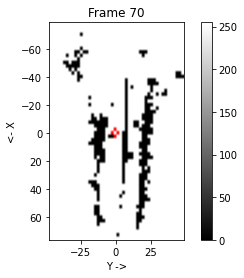

In [31]:
# white -> 1 (true) -> Free points; black -> 0 (false) -> Occupied points
dimg = np.array((o1 < points_thresh) * 255, dtype=np.uint8)
dimg = cv2.cvtColor(dimg, cv2.COLOR_GRAY2BGR)
cv2.circle(dimg, (zyi, zxi), 1, (255, 0, 0), 1)
print("255 is free and 0 is occupied")
plt.imshow(dimg, 
    extent=[yv[0], yv[-1], xv[-1], xv[0]], cmap=plt.cm.gray)
plt.title(f"Frame {frame_num}")
plt.colorbar()
plt.xlabel("Y ->")
plt.ylabel("<- X")
plt.show()

In [32]:
# Show the point cloud using Open3D
o3d_pcds = o3d.geometry.PointCloud(
    o3d.utility.Vector3dVector(pc_hfs_bref[frame_num][:3, :].T))
o3d.visualization.draw_geometries([o3d_pcds, cf])

### Inference

The following inference can be made by using different values for `frame_num` in the cells above (for this answer).

1. The occupancy grid has different size / shape, because it's discretized based on cell size and LiDAR scans can have varying ranges (according to the scene they're in).

Some observations made

1. If we choose `frame_num = 2` (3rd frame in trajectory). We get the following figure

    ![Frame 3](./results/4/1/f2.png)

    The corresponding point cloud can be observed from the cell directly above. It appears that the only way for the vehicle (red circle) to go forward was when taking a right turn. It appears that there is an elevated surface immediately ahead (seen as elevated in the point cloud below)

    ![Frame 3 in Point Cloud](./results/4/1/f2-pc.jpg)

2. If we choose `frame_num = 70` (71st frame in trajectory). We get the following figure

    ![Frame 71](./results/4/1/f70.png)

    You can spot the cars (probably on the road running beside) and other obstacles. The corresponding point cloud is shown below

    ![Frame 71 in Point Cloud](./results/4/1/f70-pc.jpg)


## Answer 2: Registered Point Cloud in each LiDAR scan

Adjust the properties for the particular frame to be visualized. Note that the entire map will be visualized here.


In [33]:
# Properties to be adjusted
frame_num = 70  # Frame (or scan) number to visualize in image
points_thresh = 10  # Number of points that mark a cell occupied
grid_dx, grid_dy = 2.5, 2   # Grid sizes along X and Y axis
gnd_lvl = -0.9  # Ground level (used for point thresholding in Z) (90 cm below bref)

In [34]:
# All points in the map frame
pc_map_gref = pcsh_gref   # Map (4 x N points), homogenized coordinates


In [35]:
pc_map_gref.shape

(4, 9413461)